# Data 100 Final Project

<b> Authors:</b> Ru Pei and Kevin Tang

For our Data 100 Final Project, we will be conducting analysis using the Basketball Dataset. 

## Motivating Question

<b> Is there a way to accurately predict whether a team will make the post-season based on historical data? </b> 

The subsequent analysis primarily aims to answer that question. We recognize that the most exiting moments of an NBA season typically occur in the postseason. Being able to accurately predict if a given team will advance or not has implications on a large variety of stakeholders (i.e. management, sports betters, players, etc). 

In answering that motivating question, we'll implicitly answer many more. These include:
- Empirically, what factors are most important in determining playoff qualification chances?
- To the casual fan, are the results largely intuitive, or are they somewhat surprising?
- Do in-game statistics (provided by the given data) paint the whole story? Are there other factors that are of importance?
- How do these statistics show how the game has evolved in the past decade?

Let's set up the notebook and take a look at the provided data.

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from decimal import Decimal

# ignoring warnings
warnings.filterwarnings('ignore')

In [2]:
# tweaking preferences
pd.set_option('display.max_columns', None)
np.random.seed(100)

In [6]:
# importing data from given csv files
scores = pd.read_csv('2012-18_officialBoxScore.csv')
player_scores = pd.read_csv('2012-18_playerBoxScore.csv')
standings = pd.read_csv('2012-18_standings.csv')
team_scores = pd.read_csv('2012-18_teamBoxScore.csv')
college = pd.read_csv('college.csv')

# importing external data that supplements our models in the future
# @source: https://hoopshype.com/salaries/2016-2017/ for salary info
# @source: https://www.kaggle.com/hrfang1995/nba-drafts-of-19472018#NBA_Full_Draft_1947-2018.csv for draft info
draft_cap = pd.read_csv('draft_cap.csv')

### 1. Data Cleaning

We're going to clean the data given to us into a relevant tabular format (i.e. indexed by season and team), making it easier for us to explore the nuances of our question.

In [7]:
def dateToSeason(df, date_col, drop=True):
    """
    df: Pandas Dataframe
    date_col: String that references the column name of the date
    drop: Boolean to indicate if original date columns will be dropped
    
    return: An augmented Dataframe that converts dates into their respective NBA Season"""
    
    # define the range of dates that fall under each season
    season_range = {'2012/13': (df[date_col] >= '2012-10-30') & (df[date_col] <='2013-04-17'), \
          '2013/14': (df[date_col] >= '2013-10-29') & (df[date_col] <='2014-04-16'), \
          '2014/15': (df[date_col] >= '2014-10-28') & (df[date_col] <='2015-04-15'), \
          '2015/16': (df[date_col] >= '2015-10-27') & (df[date_col] <='2016-04-13'), \
          '2016/17': (df[date_col] >= '2016-10-25') & (df[date_col] <='2017-04-12'), \
          '2017/18': (df[date_col] >= '2017-10-17') & (df[date_col] <='2018-04-11')}

    # edit the Dataframe
    seasons_data = []
    for key in season_range.keys():
        curr = df.loc[season_range[key]]
        curr['season'] = [key]*len(curr)
        if drop:
            curr.drop(columns=[date_col], inplace=True)
        seasons_data.append(curr)

    return pd.concat(seasons_data)

In [8]:
scores_cpy = scores.copy()

# remove all the opponent stats because they are repeated later
scores_cpy = scores_cpy.iloc[:,:61]

#remove unnecessary columns
scores_cpy.drop(columns=['gmTime', 'seasTyp', 'offLNm', 'offFNm', 'teamConf', 'teamDiv', 'teamLoc', 'teamMin', 'teamDayOff'], 
                inplace=True)

# remove duplicate rows
scores_cpy.drop_duplicates(inplace=True)

# adjust the date to be indicative of the NBA Season, a much more meaningful label
scores_cpy['gmDate'] = pd.to_datetime(scores_cpy['gmDate'])
all_seasons = dateToSeason(scores_cpy, 'gmDate')

# one-hot-encoding for Win/Loss to be 1/0. Note that we drop one of these columns because they are linearly dependent
win = pd.get_dummies(all_seasons['teamRslt'], prefix='Result', drop_first = True)['Result_Win']
all_seasons['Win'] = win
all_seasons.drop(columns='teamRslt', inplace=True)

# for each season, find the team's average stats 
stats_by_season = all_seasons.groupby(['season', 'teamAbbr']).mean()

In [9]:
# clean the standings table to work out play-off booleans
# first make dates in date format and then separate by seasons
standings['stDate'] = pd.to_datetime(standings['stDate'])
all_standings = dateToSeason(standings, 'stDate', drop=False)

# find standings at end of the season
end_dates = ['2013-04-17', '2014-04-16', '2015-04-15', '2016-04-13', '2017-04-12', '2018-04-11']
all_standings = all_standings[all_standings['stDate'].isin(end_dates)]
all_standings.drop(columns='stDate', inplace=True)
rankings = all_standings[['teamAbbr', 'rank', 'season']]
rankings = rankings.groupby(['season', 'teamAbbr']).mean()

In [10]:
# join the rankings and stats_by_season so we know the standings of teams at end of each season
all_data = rankings.join(stats_by_season, how='inner')

# add a boolean value of whether they make playoffs
all_data['playoffs'] = (all_data['rank'] <= 8).astype(int)
all_data.drop(columns='rank', inplace=True)

In [11]:
# clean draft and salary data to aggregate and index by team and season
# draft_cap.drop(columns=['Unnamed: 0'], inplace=True)
# draft_cap.rename(columns={'Team': 'teamAbbr'}, inplace=True)
# draft_cap.groupby(['season', 'teamAbbr']).mean()
# draft_cap.set_index(['season', 'teamAbbr'], inplace= True)

In [12]:
# add draft pick and salary data to all data
# all_data = all_data.join(draft_cap, how='inner')

# take a look at the final primary table
all_data.head()

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
season  teamAbbr                                                        
2012/13 ATL       97.951220  24.475610  14.865854  8.097561  4.500000   
        BKN       96.878049  20.341463  14.707317  7.304878  4.768293   
        BOS       96.518519  22.753086  14.580247  8.234568  4.506173   
        CHA       93.426829  19.353659  14.073171  7.195122  5.841463   
        CHI       93.182927  23.000000  14.280488  7.170732  5.085366   

                     teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
season  teamAbbr                                                         
2012/13 ATL       17.963415  81.024390  37.609756  0.465584  57.841463   
        BKN       18.292683  79.804878  35.878049  0.449987  58.341463   
        BOS       21.197531  79.740741  37.049383  0.466365  62.580247   
        CHA       19.048780  81.085366  34.426829  0.425313  64.024390   
        CHI       19.719512  81.682927  35.682927  0.438539  66.256098   

                    team2PM   team2P%    team3PA   team3PM   team3P%  \
season  teamAbbr                                                       
2012/13 ATL       29.000000  0.504110  23.182927  8.609756  0.373288   
        BKN       28.219512  0.484071  21.463415  7.658537  0.356373   
        BOS       30.901235  0.496393  17.160494  6.148148  0.360021   
        CHA       28.707317  0.448746  17.060976  5.719512  0.333800   
        CHI       30.243902  0.458105  15.426829  5.439024  0.350826   

                    teamFTA    teamFTM   teamFT%    teamORB    teamDRB  \
season  teamAbbr                                                         
2012/13 ATL       19.743902  14.121951  0.708479   9.243902  31.621951   
        BKN       23.878049  17.463415  0.732144  12.768293  30.000000   
        BOS       20.962963  16.271605  0.776423   8.074074  31.271605   
        CHA       25.121951  18.853659  0.753800  11.182927  29.134146   
        CHI       21.195122  16.378049  0.774287  12.512195  30.658537   

                    teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
season  teamAbbr                                                          
2012/13 ATL       40.865854  23.841463  24.768293  24.975610  23.402439   
        BKN       42.768293  26.158537  24.109756  22.731707  23.000000   
        BOS       39.345679  24.481481  24.395062  23.333333  22.493827   
        CHA       40.317073  23.195122  23.841463  22.804878  23.000000   
        CHI       43.170732  23.341463  23.621951  22.695122  22.756098   

                  teamPTS5  teamPTS6  teamPTS7  teamPTS8  teamTREB%  \
season  teamAbbr                                                      
2012/13 ATL       0.548780  0.414634  0.000000       0.0  48.451795   
        BKN       0.658537  0.219512  0.000000       0.0  52.145094   
        BOS       1.296296  0.382716  0.135802       0.0  47.419702   
        CHA       0.475610  0.109756  0.000000       0.0  47.837867   
        CHI       0.768293  0.000000  0.000000       0.0  51.261163   

                  teamASST%   teamTS%  teamEFG%  teamOREB%  teamDREB%  \
season  teamAbbr                                                        
2012/13 ATL       64.917021  0.546949  0.519068  22.058495  74.082923   
        BKN       56.829796  0.537116  0.498278  30.775823  73.941318   
        BOS       61.464602  0.543958  0.505091  19.849091  73.645579   
        CHA       55.989220  0.507712  0.460761  25.550113  71.441363   
        CHI       64.236896  0.513213  0.471784  29.168224  73.886277   

                    teamTO%  teamSTL%  teamBLK%  teamBLKR   teamPPS  \
season  teamAbbr                                                      
2012/13 ATL       14.275735  8.632868  4.807234  7.865539  1.213796   
        BKN       14.013863  8.131777  5.334624  8.313509  1.218228   
        BOS       14.087037  8.759989  4.804304  7.320688  1.216717   
        CHA       13.248724  7.782578  6.336188  9.213826  1.156089   
   

### 2. Preliminary Exploratory Data Analysis

Though intuitive, we wanted to substantiate our hypothesis from the data (that prior performance is indicative of future performance). Let's visualize how teams' rankings have adjusted over time.

Note, with 30 teams, it would be almost impossible to try to visualize ranking movement over time of the entire NBA. Instead, we have segmented our visualizations into the 6 divisions. Some quick research shows that the composition of these divisions has not changed within the past 8 years; hence, we will run into no issues with contigency. We also assume that cases of rebranding (i.e. the Charlotte Bobcats rebranded into the Hornets), have no serious implications on team performance.

In [13]:
# flatten the multi-indexed rankings dataframe
flattened_rankings = pd.DataFrame(rankings.to_records())

# use regex to convert the String season into a meaningful int
start_years = flattened_rankings['season'].str.extract('(.*)\/')[0]
flattened_rankings['startYear'] = pd.to_numeric(start_years)

# introduce divisions and take relevant columns
division_rankings = flattened_rankings.merge(scores, on='teamAbbr').groupby(['teamAbbr', 'startYear']).first()
division_rankings = pd.DataFrame(division_rankings[['rank', 'teamDiv']].to_records())

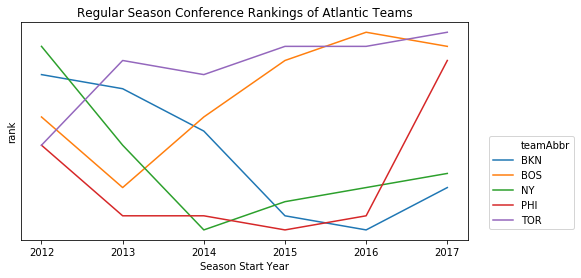

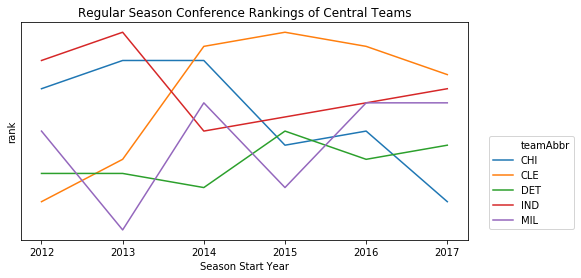

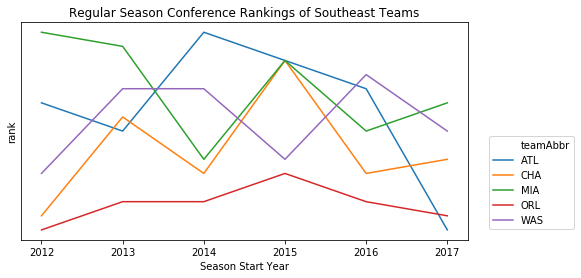

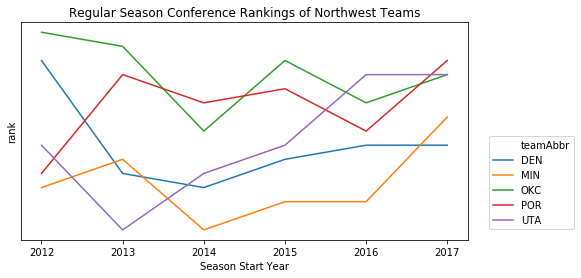

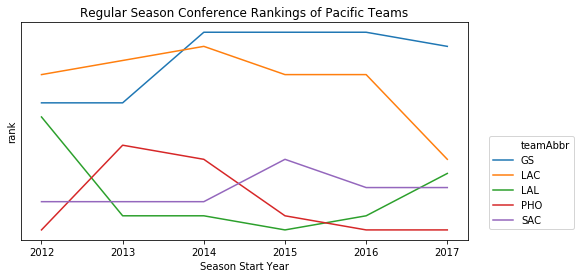

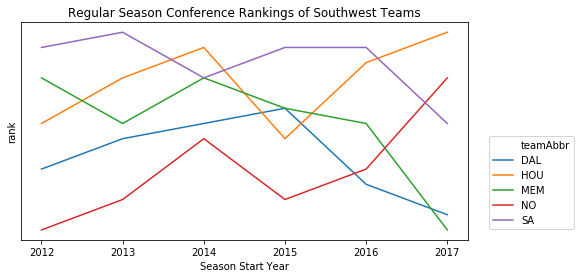

In [14]:
# list of all possible divisions
divisions = ['Atlantic', 'Central', 'Southeast', 'Northwest', 'Pacific', 'Southwest']

# plotting for the separate divisions
for division in divisions:
    plt.figure(figsize=(8, 4))
    atlantic = sns.lineplot('startYear', 'rank', data=division_rankings[division_rankings['teamDiv'] == division], 
                            hue='teamAbbr')
    atlantic.legend(loc='bottom right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.title('Regular Season Conference Rankings of {} Teams'.format(division))
    plt.xlabel('Season Start Year')
    plt.yticks(range(1))
    
    # inverting y axis because lower ranks are better, makes the visualization more intuitive
    plt.gca().invert_yaxis()
    plt.show();

These visualizations show us that most teams tend to either fluctuate around the same standings or progressively trend towards either towards the top or the bottom of the standings. Teams that 'spike' between positions (like Charlotte in Southeast division) are pretty uncommon, or that quickly rise up the standings (like Philadelphia in the Atlantic division from the 16/17 to 17/18 season). Without rigorous proof, we can see this trend is valid. We will account for light fluctuations through a moving average of statistics over the past 3 seasons.

After some external research, we discovered that sudden team improvements (like the 76ers as mentioned above) are largely due to obtaining leverage after obtaining high draft picks in the NBA lottery (either through getting a new young talent to build a team around, or trading for better components).

### 3. Feature Engineering/More EDA

Now, we want to discover which features are most correlated to success, potentially identify redudancy/multicollinearity, and identify significant features that our data doesn't fully address.

In [36]:
# add a column of whether the team made playoffs in the next season
# 2018-19 season playoffs data which is manually inputted from NBA.com
season_1819 = pd.DataFrame()
season_1819['teamAbbr'] = rankings.index.get_level_values('teamAbbr').unique().tolist()
season_1819['playoffs'] = [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
season_1819['season'] = ['2018/19'] * len(season_1819)
seasons_playoff = all_data['playoffs'].reset_index()
seasons_playoff.append(season_1819)

# remove the 2012-13 season data
seasons_playoff = seasons_playoff[seasons_playoff['season'] != '2012/13']
seasons_playoff.columns = ['next_season', 'teamAbbr', 'next_playoffs']

In [37]:
def addNextSeason(df):
    """
    df: selected Pandas Dataframe
    
    return: augmented version of df that includes a column for the next season label
    """
    # map current season to next season
    dates_dict = {'2012/13': '2013/14', \
                 '2013/14': '2014/15', \
                 '2014/15': '2015/16', \
                 '2015/16': '2016/17', \
                 '2016/17': '2017/18', \
                 '2017/18': '2018/19'}
    df_new = df.reset_index().copy()
    df_new['next_season'] = df_new['season'].map(dates_dict)
    return df_new.merge(seasons_playoff, how='inner', on=['teamAbbr', 'next_season'])

In [38]:
def addMovingAverage(df):
    # create a new table which has the mean of past 3 seasons and whether the team makes playoffs next season. 
    # Note the input into 'rolling' is the # seasons for our moving average window
    mov_avg_data = df.groupby('teamAbbr').rolling(3).mean()

    # remove the NaN rows which exist because first 2 seasons for MA don't exist 
    mov_avg_data = mov_avg_data.dropna()
    mov_avg_data.index = mov_avg_data.index.droplevel(2)
    
    return addNextSeason(mov_avg_data)

In [39]:
mov_avg_data_new = addMovingAverage(all_data)

Now, let's see which of our current features is most correlated with playoff qualification.

In [40]:
# finding the top 10 features in correlation magnitude with next year playoff qualification
# We start the index at 1 to remove the perfect correlation between next_playoff and itself
mov_avg_data_new.corr()['next_playoffs'].abs().sort_values(ascending=False)[1:11]

teamEDiff    0.562242
Win          0.552999
playoffs     0.545371
teamDrtg     0.490565
teamTS%      0.461633
teamEFG%     0.448068
team2P%      0.434102
teamFG%      0.432761
teamPPS      0.427823
teamOrtg     0.423029
Name: next_playoffs, dtype: float64

To gain a better understanding of the nuances of our question (and for curiosity's sake), let's also take a look at the worst features.

In [41]:
# finding the worst 10 features in correlation magnitude with next year playoff qualification
mov_avg_data_new.corr()['next_playoffs'].abs().sort_values()[:10]

teamFTA      0.005635
team2PM      0.008680
teamOREB%    0.013076
teamPTS7     0.016132
teamTO       0.016778
teamPF       0.052860
teamFTM      0.059125
teamTRB      0.064153
teamTO%      0.067618
teamDREB%    0.071552
Name: next_playoffs, dtype: float64

Some of these findings are largely intuitive. For example, we would expect that teams with more wins will naturally do better, and given our findings in previous sections, that teams who have been making the playoffs in recent years to do so again. On the other hand, since free throws have inherently lower point values, they matter less when compared to field goals. "Period 7" (or the third period of overtime) is also extremeley rare. Hence, performance in that period also isn't a good indication.

Some, however, are not. These include turnovers not contributing that much (though they seem to be a pinacle point of statistical analysis by many basketball pundits), and in an era of the game where 3PT shooting is so important, it's interesting to see it's still not as raw field goal or true shooting percentage. Let's take a look to see if time is a factor that relates to this surprising phenomenon with 3PT shooting.

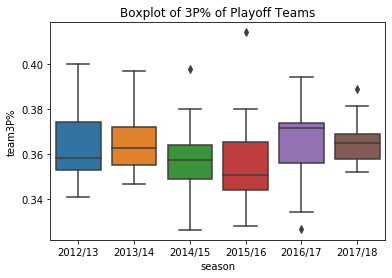

In [61]:
playoff_teams = all_data[all_data['playoffs'] == 1]
playoff_teams = pd.DataFrame(playoff_teams.to_records())
sns.boxplot('season', 'team3P%', data=playoff_teams)
plt.title("Boxplot of 3P% of Playoff Teams");

Wonder who that insane outlier that shot over 41% collectively as a team (2015/16 season) is? I think most casual NBA fans in the Bay Area can accurately guess.

In [54]:
playoff_teams[playoff_teams['team3P%'] > 0.41]['teamAbbr']

56    GS
Name: teamAbbr, dtype: object

That 2016/17 outlier that shot horribly from outside the perimeter was also of interest to us.

In [57]:
playoff_teams[(playoff_teams['team3P%'] < 0.33) & (playoff_teams['season'] == '2016/17')]['teamAbbr']

77    OKC
Name: teamAbbr, dtype: object

which honestly shouldn't be a surprise when you realize Russel Westbrook shot an average of 7.2	3s per game at only 34.3%. 

Source: https://www.basketball-reference.com/players/w/westbru01.html

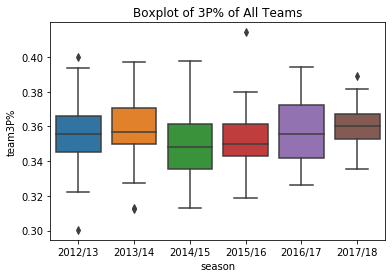

In [59]:
all_teams = pd.DataFrame(all_data.to_records())
sns.boxplot('season', 'team3P%', data=all_teams)
plt.title("Boxplot of 3P% of All Teams");

all NBA teams performed slightly worse, but interestingly enough, there wasn't the surge of tendency to shoot better from outside the arc as we anticipated. Though it's surprising and won't help us with modelling, it was a really cool observation to make, and probably something on interest that will come up in our casual basketball conversations in the future.

We also notice that a large majority of high correlation magnitudes are based on shooting efficiency. We hypothesize that there's probably much redundancy in these features.

In [ ]:
shooting_metrics = mov_avg_data_new[['teamTS%', 'teamEFG%', 'team2P%', 'teamFG%', 'teamPPS']]

plt.figure(figsize=(10, 7))
shot_heatmap = sns.heatmap(shooting_metrics.corr(), annot=True)
plt.title("Correlation Heatmap between Shooting Metrics")

# this line of code below fixes a sns.heatmap bug with newer iterations of matplotlib
shot_heatmap.set_ylim(0, 5);

Unsurprisingly, these features are highly correlated. We should probably only use one. We choose True Shooting Percentage because it's both the highest correlated and the best comprehensive metric for all shooting efficiency.

We now go through all the possible features again, repeat this process, and pick out a set of features that are both indicative, and uncorrelated with each other. An interesting observation from the heatmap below is that defensive rating seems to be negatively correlated with playoff contention. This seems counter-intuitive; after all, "defense wins championships." It's worth noting that lower defensive ratings are actually better (i.e. lower scores mean better defenses) given the NBA's definition. Hence, it's not really that counterintuitive.

In [ ]:
final_features = ['Win', 'playoffs', 'teamDrtg', 'teamTS%']

final_mov_avg = mov_avg_data_new[final_features + ['next_playoffs']]
plt.figure(figsize=(10, 7))
shot_heatmap = sns.heatmap(final_mov_avg.corr(), annot=True)
plt.title("Correlation Heatmap between Final Features")

# this line of code below fixes a sns.heatmap bug with newer iterations of matplotlib
shot_heatmap.set_ylim(0, 5);

Even after selecting highly correlated features that have seemingly little to do with each other at first glance, there's still a significant amount of redundancy.

### 4. Initial Model Selection

Let's try to fit a diverse range of models to see how well we can predict NBA playoff qualification with only our given dataset

In [ ]:
# Now we have all our training data and labels
training_data = mov_avg_data_new.drop(columns = ['teamAbbr', 'season', 'next_season'])

# shuffle all the training data so that time (i.e. same season) isn't a bias in CV
# training_data = training_data.sample(frac=1, random_state=100).reset_index(drop=True)

X = training_data.drop(columns = 'next_playoffs')
y = training_data['next_playoffs']

# split off a portion of the data to use as test data. Shuffling is automatically done.
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

# normalize the data 
mm_scaler = preprocessing.MinMaxScaler()
train_x = pd.DataFrame(mm_scaler.fit_transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(mm_scaler.transform(test_x), columns=test_x.columns)

#### Model 4.1: Naive Baseline Predictor

We'll create a baseline predictor that simply predicts playoff qualification based on past season's performance (i.e. teams who made the playoffs in the past will make it again).

In [ ]:
# using a dictionary of dates, have a column of the next season
baseline_df = addNextSeason(all_data)

baseline_x = baseline_df.drop(['next_playoffs', 'season', 'teamAbbr', 'next_season'], axis=1)
baseline_y = baseline_df['next_playoffs']
base_train_x, base_test_x, base_train_y, base_test_y = train_test_split(baseline_x, baseline_y, test_size=0.1, random_state=42)

# normalize the data using minmaxscaler
mm_scaler = preprocessing.MinMaxScaler()
base_train_x = pd.DataFrame(mm_scaler.fit_transform(base_train_x), columns=base_train_x.columns)
base_test_x = pd.DataFrame(mm_scaler.transform(base_test_x), columns=base_test_x.columns)

In [ ]:
class naive_predictor:
    def init(self):
        pass
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self):
        return self.X['playoffs'] == 1.0
    
    def score(self):
        return np.average((self.X['playoffs'] == 1.0) == self.y)

    
baseline = naive_predictor()
baseline.fit(base_train_x, base_train_y.astype(float).reset_index()['next_playoffs'])
baseline.score()

Roughly 76% accuracy is decent for a baseline/naive predictor. It does beat guessing at random (which would converge to a 50% accuracy). Let's see if we can make our predictor more sophisticated in future iterations.

#### Model 4.2a: Majority Predictor

Let's enhance our naive predictor to account for our feature engineering. Namely, we'll predict that a team makes the playoffs if the team made more than 50% of the playoffs in the past 3 seasons (since there are exactly 3 seasons, it's impossible to qualify exactly 50% of the time).

In [ ]:
class mav_predictor:
    def init(self):
        pass
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self):
        return self.X['playoffs'] > 0.5
    
    def score(self):
        return np.average((self.X['playoffs'] > 0.5) == self.y)
    
    def wrong_predictions(self):
        return self.X[self.predict() != self.y]
    
mav = mav_predictor()
mav.fit(train_x, train_y.astype(float).reset_index()['next_playoffs'])
mav.score()

Using the moving average helps us make much better predictions, even without a sophisticated mechanism. This reinforces our idea that we can somewhat guess playoff qualification well using recent past performance. 

#### Model 4.3a: Logistic Regression with Feature Selection

We'll now perform logistic regression on our selected features.

In [ ]:
train_x_cleaned = train_x[final_features]
c_vals = [0.001, 0.01, 0.1, 1, 10, 20, 50]

logreg_score = []
for c in c_vals:
    logreg_naive = LogisticRegression(C=c, random_state=42)
    logreg_score.append(np.mean(cross_val_score(logreg_naive, train_x_cleaned, train_y, cv=5)))

plt.plot(c_vals, logreg_score)
plt.title('Cross Validation Score for Logistic Regression')
plt.xlabel('C parameter value')
plt.ylabel('CV accuracy');

In [ ]:
logreg_naive = LogisticRegression(C=50, random_state=42)
logreg_naive.fit(train_x_cleaned, train_y)
logreg_preds = logreg_naive.predict(test_x[final_features])
logreg_accuracy = accuracy_score(test_y, logreg_preds)
print('The test accuracy of logistic regression is: ', logreg_accuracy)

#### Model 4.3b: Decision Tree Classifier with Feature Selection

In [ ]:
decisiontree_naive = DecisionTreeClassifier(random_state=42)
decisiontree_score = np.mean(cross_val_score(decisiontree_naive, train_x_cleaned, train_y, cv=5))
print('The cross validation accuracy of decision tree is: ', decisiontree_score)

decisiontree_naive.fit(train_x_cleaned, train_y)
decisiontree_preds = decisiontree_naive.predict(test_x[final_features])
decisiontree_accuracy = accuracy_score(test_y, decisiontree_preds)
print('The test accuracy of decision tree is: ', decisiontree_accuracy)

Note, the lower CV score is expected due to the nature of decision trees to overfit.

In [ ]:
decisiontree_naive.fit(train_x_cleaned, train_y)
plt.figure(figsize=(15,10))
plot_tree(decisiontree_naive, feature_names = train_x_cleaned.columns, \
          filled=True, label='root', \
          impurity=False, \
         class_names = ['playoffs', 'no playoffs']);

#### Model 4.3c: Random Forest Classifier with Feature Selection

In [ ]:
depths = [1, 5, 10, 15, 20]
num_trees = [1, 5, 10, 100, 1000]
max_features = ['auto', 'log2', None]
randomforest_scores = []
best_depth = -100
best_num_trees = -100
best_split = -100
max_score = -10000
for depth in depths:
    for n in num_trees:
        for m in max_features:
            randomforest = RandomForestClassifier(max_depth = depth, n_estimators=n, random_state=42, \
                                                  max_features=m)
            curr = np.mean(cross_val_score(randomforest, train_x, train_y, cv=5))
            if curr >= max_score:
                best_depth = depth
                best_num_trees = n
                max_score = curr
                best_split= m
print('The best cross validation score for random forest is: ', max_score)
print('The best depth to use is: ', best_depth)
print('The best number of trees to use is: ', best_num_trees)
print('The best number of splits to use is: ', best_split)

In [ ]:
randomforest = RandomForestClassifier(max_depth = 5, n_estimators=5, random_state=42, \
                                     max_features='log2')
randomforest.fit(train_x, train_y)
randomforest_preds = randomforest.predict(test_x)
randomforest_accuracy = accuracy_score(test_y, randomforest_preds)
print('The test accuracy of random forest is: ', randomforest_accuracy)

#### Model 4.4: KNN

Let's go above and beyond and incorporate a (largely underrated) classification scheme.

<b> TODO: Kevin maybe add a link to the 189 lecture where the prof talks about how it's underrated </b>

In [ ]:
num_neighbours = [1, 5, 10, 20, 50, 100]
neigh_score= []
for n in num_neighbours:
    neigh = KNeighborsClassifier()
    neigh_score.append(np.mean(cross_val_score(neigh, train_x_cleaned, train_y, cv=5)))
plt.plot(num_neighbours, neigh_score)
plt.title('The cross validation accuracy of K-NN')
plt.xlabel('Number of neighbours')
plt.ylabel('CV accuracy');

In [ ]:
neigh = KNeighborsClassifier(n_neighbors= 50)
neigh.fit(train_x_cleaned, train_y)
neigh_preds = neigh.predict(test_x[final_features])
neigh_accuracy = accuracy_score(test_y, neigh_preds)
print('The test accuracy of K-NN is: ', neigh_accuracy)

### 5. Additional Feature Engineering

To find ways to improve our models, we should probably take a look at the teams where our slightly mare sophisticated maj classifier didn't guess right.

In [ ]:
wrong_X = mav.wrong_predictions()

# reintroduce the names and seasons for these teams
team_info = mov_avg_data_new[mov_avg_data_new.index.isin(wrong_X.index)]
wrong_X = pd.DataFrame(StandardScaler().fit_transform(wrong_X), columns=wrong_X.columns, index=wrong_X.index)

wrong_X.head()

In [ ]:
wrong_y = train_y[train_y.index.isin(wrong_X.index)]

In [ ]:
clustering = AgglomerativeClustering(n_clusters=2).fit(wrong_X)
clustering_pca = PCA(2)
principal_df = pd.DataFrame(data = clustering_pca.fit_transform(wrong_X), columns = ['PC 1', 'PC 2'], index=wrong_X.index)
principal_df['cluster'] = clustering.labels_
principal_df['team'] = team_info['teamAbbr']

# the team label includes team name, season, and if they were predicted to make the playoffs next season
playoff_guess = (team_info['playoffs'] > 0.5).astype(str)
principal_df['team'] = principal_df.team.map(str) + " " + team_info['season'] + " " + playoff_guess

# inspiration source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (13,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = principal_df['cluster'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'PC 1']
               ,principal_df.loc[indicesToKeep, 'PC 2']
               ,c = color
               ,s = 50)
    
indices = principal_df.index.to_list()
for i, label in enumerate(principal_df['team']):
    x = principal_df.loc[indices[i], 'PC 1']
    y = principal_df.loc[indices[i], 'PC 2']
    ax.annotate(label, (x, y+0.2)) 

ax.legend(targets)
ax.grid()

We did some external research to see what could have caused these incorrect projections for these teams. Ultimately, nothing really came out of this tactic. We simply could not find the relationship between the clustered teams. Though we are both casual basketball fans, we probably didn't have enough domain knowledge to be able to tie these specific teams and their performance in their respective seasons together.

Nonetheless, using the insights drawn from earlier EDA, we recognized that draft prospects and budgeting constraints were 2 off-court factors that contribute to a team's success. The following cells includes our process of gathering and parsing additional data into a csv file. These cells don't technically need to be run, as the cleaned csv is also included in the folder, but are included as reference.

In [3]:
# @source: https://www.kaggle.com/hrfang1995/nba-drafts-of-19472018#NBA_Full_Draft_1947-2018.csv
drafts = pd.read_csv('NBA_Full_Draft_1947-2018.csv')

In [4]:
# selecting relevant years
drafts = drafts[drafts['Year'] >= 2012]
drafts = drafts[drafts['Year'] < 2018]

# first round picks only
drafts = drafts[drafts['Pick'] <= 30]
team_drafts = drafts[['Team', 'Year', 'Pick']]

In [5]:
# necessary dictionaries to keep data labels consistent
team_dict = {'ATL': 'ATL', \
    'BRK': 'BKN' ,\
    'BOS': 'BOS', \
    'CHA': 'CHA', \
    'CLE': 'CLE', \
    'CHI': 'CHI', \
    'DAL': 'DAL', \
    'DEN': 'DEN', \
    'DET': 'DET', \
    'HOU': 'HOU', \
    'IND': 'IND', \
    'GSW': 'GS', \
    'IND': 'IND', \
    'LAL': 'LAL', \
    'LAC': 'LAC', \
    'MEM': 'MEM', \
    'MIA': 'MIA', \
    'NOH': 'NO', \
    'NOP': 'NO', \
    'NYK': 'NY', \
    'ORL': 'ORL', \
    'SAS': 'SA', \
    'MIL': 'MIL', \
    'MIN': 'MIN', \
    'OKC': 'OKC', \
    'PHI': 'PHI', \
    'PHO': 'PHO', \
    'POR': 'POR', \
    'SAC': 'SAC', \
    'TOR': 'TOR', \
    'UTA': 'UTA', \
    'WAS': 'WAS', \
    'CHH': 'CHA'
}

seasons_dict = {
    2012: '2012/13', \
    2013: '2013/14', \
    2014: '2014/15', \
    2015: '2015/16', \
    2016: '2016/17', \
    2017: '2017/18', \
    2018: '2018/19'    
}

#### 5.1 Re-doing Logistic Regression with draft pick and salary cap

In [ ]:
train_x_cleaned = train_x[final_features + ['Pick', 'salarycap']]
c_vals = [0.001, 0.01, 0.1, 1, 10, 20, 50]

logreg_score = []
for c in c_vals:
    logreg_draft_cap= LogisticRegression(C=c)
    logreg_score.append(np.mean(cross_val_score(logreg_draft_cap, train_x_cleaned, train_y, cv=5)))

plt.plot(c_vals, logreg_score)
plt.title('Cross Validation Score for Logistic Regression')
plt.xlabel('C parameter value')
plt.ylabel('CV accuracy');

In [ ]:
logreg_draft_cap = LogisticRegression(C=50)
logreg_draft_cap.fit(train_x_cleaned, train_y)
logreg_draft_cap_preds = logreg_draft_cap.predict(test_x[final_features + ['Pick', 'salarycap']])
logreg_draft_cap_accuracy = accuracy_score(test_y, logreg_draft_cap_preds)
print('The test accuracy for Logistic Regression with the additional features is: ', logreg_draft_cap_accuracy)

### 99. Misc Stuff for now

In [ ]:
sns.heatmap(train_x.corr())

#### 5. Using PCA + logistic regression
This uses the original train_x (of all features) and tries to find the best features on its own via PCA.

In [ ]:
pcas = [1, 5, 15, 20, 25, 30, 50, 100]
pca_lr_score = []
for val in pcas:
    pca = PCA(val)
    logistic = LogisticRegression(max_iter=10000, tol=0.5)
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    pca_lr_score.append(np.mean(cross_val_score(pipe, train_x, train_y, cv=5)))
    
plt.plot(pcas, pca_lr_score)
plt.title('Logistic Regression with PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('CV Accuracy')
print('PCA + logistic regression cross validation accuracy: ', max(pca_lr_score))

In [ ]:
pca_best = PCA(20)
logistic_pca = LogisticRegression(max_iter=10000, tol=0.5)
pipe = Pipeline(steps=[('pca', pca_best), ('logistic', logistic_pca)])
pipe.fit(train_x, train_y)
pipe_preds = pipe.predict(test_x)
pipe_accuracy = accuracy_score(test_y, pipe_preds)
print('The test accuracy of PCA with Logistic Regression is: ', pipe_accuracy)

### Reference Stuff
Data Science Lifecycle:

Either
1. Ask a Question
2. Obtain Data
3. Understand the Data
4. Understand the World/repeat

Or (probably more relevant to our case)
1. Obtain Data
2. Understand the Data
3. Ask a Question
4. Obtain more Data
5. Understand combined data
6. Understand the world/repeat

### Priorities:
1. Build actual naive one (Ru)
    - past 1 season to predict next season playoff. 
2. Find better features (Kevin) 
    - eg. draft picks, budget, conference, division
3. More visualisations (split)
    - cluster teams -> PCA on moving_avg df and then k-means clustering
    - bar chart -> all the models, before/after adding the 'better features' above
    - boxplot -> maybe for budget over 5 years, w/ NBA teams as categorical. Find correlation between the boxplot and their performance 
4. Add k-nn model (Ru)
5. Rename some things eg. mov_avg_model_new and mov_avg_model_new_features

### Questions
– (i) What were two or three of the most interesting features you came across for your particular
question? <br>

– (ii) Describe one feature you thought would be useful, but turned out to be ineffective. <br>
    - a lot of the features were correlated. eg. having true shooting %, we don't need other shooting related.
    - 3pt efficiency was not that indicative of playoffs. Maybe it's because in older seasons, it was not as highly valued as it is nowadays. (include visualisation of how avg 3pt% changed over time) 
    
– (iii) What challenges did you find with your data? Where did you get stuck? <br>
    - multicollinearity, had to find our own data (eg. draft/budget) to improve model 
    
– (iv) What are some limitations of the analysis that you did? What assumptions did you make
that could prove to be incorrect? <br>
    - data size -> because we used moving avg, only had 120 data points total 
    - game changes over time. eg. see 3pt is more valuable now but big men were more efficient before 
        - we tried to mitigate this by using moving avg so we only consider the past 3 seasons 

– (v) What ethical dilemmas did you face with this data? <br>
    - representation 
    - Ru 

– (vi) What additional data, if available, would strengthen your analysis, or allow you test some
other hypothesises? <br>
    - NCAA -> NBA we wanted to calc player efficiency which required their team stats not just their personal stats 
    - what players played in each team in each season 
    - more historical data to see if game dynamics play a huge role in predicting playoffs

– (vii) What ethical concerns might you encounter in studying this problem? How might you
address those concerns? <br>
    - Ru


### TODOS:
- visualisations eg. EDA, heatmap correlation of features, fine-tuning accuracy for random forest, visualisation for pca clusters, simple histograms, should do some sort of time series test
- can look at how fivethirtyeight defines a 'good' basketball team. Test it to see if it actually holds true in this dataset 
- potential features to add: draft pick #, budget
- predict how good in NBA based on NCAA stats (should try to find a good stat)
- compare the pros/cons for the different classification models based on the same dataset
- seeing if better than baseline (predicting next yr from this year if they're in playoffs)
- fine_tune hyperparameters for PCA + logistic regression model

- Code organisation:
    - should make the cleaning all in one function 

other ideas:
- see what type of shots/position is most popular over time
- salary efficiency 

### A list of observations to include in the report:
- originally, when using all the given stats, the features were quite correlated